In [ ]:
# Cell 1
import os
import math
import time
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


**A — Character LSTM Text Generator (toy)**


In [ ]:
# Cell 2A
# A tiny corpus (replace with a larger text file for real results)
text = (
    "To be, or not to be, that is the question:\n"
    "Whether 'tis nobler in the mind to suffer\n"
    "The slings and arrows of outrageous fortune,\n"
    "Or to take arms against a sea of troubles\n"
    "And by opposing end them."
)
print("Corpus size (chars):", len(text))

# build vocab
chars = sorted(list(set(text)))
itos = {i:ch for i,ch in enumerate(chars)}
stoi = {ch:i for i,ch in itos.items()}
vocab_size = len(chars)
print("Vocab size:", vocab_size)


Corpus size (chars): 197
Vocab size: 31


In [ ]:
# Cell 3A
class CharDataset(Dataset):
    def __init__(self, text, seq_len=40):
        self.text = text
        self.seq_len = seq_len
        self.vocab = sorted(list(set(text)))
        self.stoi = {ch:i for i,ch in enumerate(self.vocab)}
        self.data = [self.stoi[c] for c in text]
    def __len__(self):
        return max(1, len(self.data) - self.seq_len)
    def __getitem__(self, idx):
        seq = self.data[idx:idx+self.seq_len]
        target = self.data[idx+1:idx+self.seq_len+1]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

seq_len = 40
ds = CharDataset(text, seq_len=seq_len)
loader = DataLoader(ds, batch_size=8, shuffle=True)


In [ ]:
# Cell 4A
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=32, hidden_size=128, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hc=None):
        x = self.embed(x)  # B x T x E
        out, hc = self.lstm(x, hc)
        logits = self.fc(out)  # B x T x V
        return logits, hc

model_lstm = CharLSTM(vocab_size, embed_size=32, hidden_size=128).to(device)
print(model_lstm)


CharLSTM(
  (embed): Embedding(31, 32)
  (lstm): LSTM(32, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=31, bias=True)
)


In [ ]:
# Cell 5A
lr = 0.01
opt = optim.Adam(model_lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

epochs = 200  # small dataset; character-level trains quickly
print_every = 50

for epoch in range(1, epochs+1):
    model_lstm.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        opt.zero_grad()
        logits, _ = model_lstm(x)
        # reshape for loss: (B*T, V)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
    if epoch % print_every == 0 or epoch==1:
        avg = total_loss / len(ds)
        print(f"Epoch {epoch}/{epochs} | loss={avg:.4f}")


Epoch 1/200 | loss=2.3105
Epoch 50/200 | loss=0.0644
Epoch 100/200 | loss=0.0627
Epoch 150/200 | loss=0.0611
Epoch 200/200 | loss=0.0606


In [ ]:
# Cell 6A
def sample(model, start_str, length=200, temperature=1.0):
    model.eval()
    chars = list(start_str)
    input_seq = torch.tensor([[stoi[ch] for ch in chars]], dtype=torch.long).to(device)
    hc = None
    with torch.no_grad():
        logits, hc = model(input_seq, hc)
        last = input_seq[:, -1].unsqueeze(1)
        for _ in range(length):
            logits, hc = model(last, hc)           # logits: B x 1 x V
            probs = F.softmax(logits[:, -1, :]/temperature, dim=-1)
            idx = torch.multinomial(probs, num_samples=1)  # B x 1
            last = idx
            chars.append(itos[int(idx.cpu())])
    return ''.join(chars)

print("---- sample (temp=0.8) ----")
print(sample(model_lstm, start_str="To be", length=300, temperature=0.8))


---- sample (temp=0.8) ----
To be or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them.in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles



**B — Variational Autoencoder (VAE) on MNIST**


In [ ]:
# Cell 2B
bs = 256
transform_mnist = transforms.Compose([
    transforms.ToTensor()
])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform_mnist)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform_mnist)
train_loader_m = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
test_loader_m  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)
print("MNIST loaders ready. Batch size:", bs)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]

MNIST loaders ready. Batch size: 256


In [ ]:
# Cell 3B
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(28*28, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # mu
        self.fc22 = nn.Linear(512, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 28*28)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,28*28))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

vae = VAE(latent_dim=32).to(device)
print(vae)


VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=32, bias=True)
  (fc22): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)


In [ ]:
# Cell 4B
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1,28*28), reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
# Cell 5B
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 8

for epoch in range(1, epochs+1):
    vae.train()
    train_loss = 0
    for x, _ in train_loader_m:
        x = x.to(device)
        opt_vae.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        opt_vae.step()
        train_loss += loss.item()
    avg = train_loss / len(train_loader_m.dataset)
    print(f"Epoch {epoch}/{epochs} | Avg loss per image: {avg:.4f}")


Epoch 1/8 | Avg loss per image: 186.5578
Epoch 2/8 | Avg loss per image: 133.5524
Epoch 3/8 | Avg loss per image: 121.3877
Epoch 4/8 | Avg loss per image: 115.9454
Epoch 5/8 | Avg loss per image: 112.8630
Epoch 6/8 | Avg loss per image: 110.9029
Epoch 7/8 | Avg loss per image: 109.5966
Epoch 8/8 | Avg loss per image: 108.5700


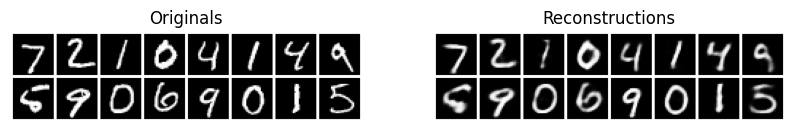

In [ ]:
# Cell 6B
vae.eval()
x, _ = next(iter(test_loader_m))
x = x.to(device)[:16]
with torch.no_grad():
    recon, mu, logvar = vae(x)
recon = recon.view(-1,1,28,28).cpu()

# show originals and reconstructions
grid_in = utils.make_grid(x.cpu(), nrow=8, pad_value=1.0)
grid_recon = utils.make_grid(recon, nrow=8, pad_value=1.0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(grid_in.permute(1,2,0).squeeze(), cmap='gray'); plt.title('Originals'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(grid_recon.permute(1,2,0).squeeze(), cmap='gray'); plt.title('Reconstructions'); plt.axis('off')
plt.show()


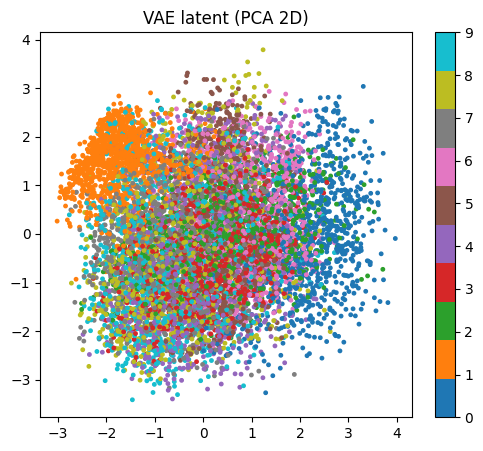

In [ ]:
# Cell 7B
vae.eval()
mus = []
labels = []
with torch.no_grad():
    for x, y in DataLoader(test_ds, batch_size=512):
        x = x.to(device)
        mu, logvar = vae.encode(x.view(-1,28*28))
        mus.append(mu.cpu().numpy())
        labels.append(y.numpy())
mus = np.concatenate(mus, axis=0)
labels = np.concatenate(labels, axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mus2 = pca.fit_transform(mus)
plt.figure(figsize=(6,5))
plt.scatter(mus2[:,0], mus2[:,1], c=labels, cmap='tab10', s=6)
plt.title('VAE latent (PCA 2D)'); plt.colorbar(); plt.show()


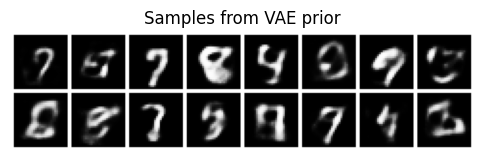

In [ ]:
# Cell 8B
with torch.no_grad():
    z = torch.randn(16, vae.latent_dim).to(device)
    samples = vae.decode(z).view(-1,1,28,28).cpu()
grid = utils.make_grid(samples, nrow=8, pad_value=1.0)
plt.figure(figsize=(6,3))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.axis('off'); plt.title('Samples from VAE prior')
plt.show()


**C — DCGAN (Generator + Discriminator) on MNIST**

In [ ]:
# Cell 2C
bs_gan = 128
transform_gan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # range [-1,1]
])
train_ds_gan = datasets.MNIST(root="./data", train=True, download=True, transform=transform_gan)
train_loader_gan = DataLoader(train_ds_gan, batch_size=bs_gan, shuffle=True, num_workers=2, pin_memory=True)
print("GAN loader ready. Batches:", len(train_loader_gan))


GAN loader ready. Batches: 469


In [ ]:
# Cell 3C
nz = 100  # latent dim
ngf = 64
ndf = 64

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64):
        super().__init__()
        self.model = nn.Sequential(
            # input z -> (ngf*4) x 7 x 7
            nn.Linear(nz, ngf*4*7*7),
            nn.BatchNorm1d(ngf*4*7*7),
            nn.ReLU(True),
        )
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1), # 7->14
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1),   # 14->28
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, ngf*4, 7, 7)
        x = self.conv_blocks(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, ndf, kernel_size=4, stride=2, padding=1), # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1), # 14->7
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf*2*7*7, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x).view(-1)

netG = Generator(nz=nz, ngf=ngf).to(device)
netD = Discriminator(ndf=ndf).to(device)
print(netG); print(netD)


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3

In [ ]:
# Cell 4C
criterion_gan = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5,0.999))
fixed_noise = torch.randn(64, nz, device=device)
real_label = 1.
fake_label = 0.


In [ ]:
# Cell 5C
epochs = 6
G_losses = []
D_losses = []

for epoch in range(1, epochs+1):
    netD.train(); netG.train()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for i, (real_images, _) in enumerate(train_loader_gan):
        bsize = real_images.size(0)
        real_images = real_images.to(device)

        # Update D: real
        netD.zero_grad()
        label = torch.full((bsize,), real_label, device=device)
        output = netD(real_images)
        lossD_real = criterion_gan(output, label)
        lossD_real.backward()

        # Update D: fake
        noise = torch.randn(bsize, nz, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output_fake = netD(fake.detach())
        lossD_fake = criterion_gan(output_fake, label)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # Update G
        netG.zero_grad()
        label.fill_(real_label)  # want generator to fool discriminator
        output_fake_forG = netD(fake)
        lossG = criterion_gan(output_fake_forG, label)
        lossG.backward()
        optimizerG.step()

        epoch_d_loss += lossD.item()
        epoch_g_loss += lossG.item()

    G_losses.append(epoch_g_loss / len(train_loader_gan))
    D_losses.append(epoch_d_loss / len(train_loader_gan))
    print(f"Epoch {epoch}/{epochs} | D_loss={D_losses[-1]:.4f} | G_loss={G_losses[-1]:.4f}")


Epoch 1/6 | D_loss=0.8367 | G_loss=1.4269
Epoch 2/6 | D_loss=0.8322 | G_loss=1.4047
Epoch 3/6 | D_loss=0.9124 | G_loss=1.3014
Epoch 4/6 | D_loss=0.9435 | G_loss=1.2903
Epoch 5/6 | D_loss=0.9668 | G_loss=1.2830
Epoch 6/6 | D_loss=0.9738 | G_loss=1.2865


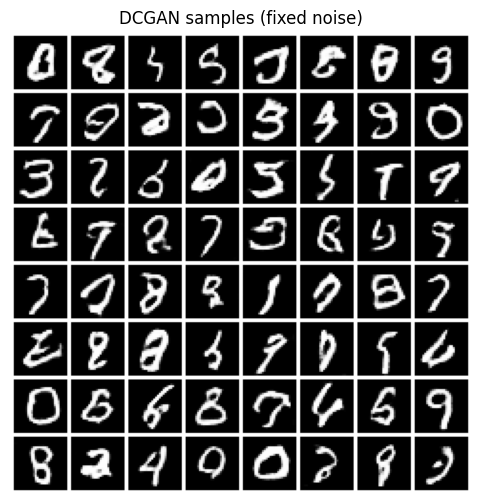

In [ ]:
# Cell 6C
netG.eval()
with torch.no_grad():
    fake = netG(fixed_noise).cpu()
# denorm from [-1,1] to [0,1] if needed (we used Tanh)
imgs = (fake + 1) / 2.0
grid = utils.make_grid(imgs, nrow=8, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.axis('off')
plt.title('DCGAN samples (fixed noise)')
plt.show()
